In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [28]:
def fit_svd(X, M=1):
    U, s, V = np.linalg.svd(X, full_matrices=False)
    return U[:, :M] @ (np.diag(s[:M]) @ V[:M, :])

In [29]:
def matrix_completion(X, mask, M=1, max_iter=50, tol=1e-6, verbose=False):
    Xhat = X.copy()
    # initialize missing with column means
    col_means = np.nanmean(X, axis=0)
    inds = np.where(mask)
    Xhat[inds] = np.take(col_means, inds[1])
    rel_errors = []
    mss0 = np.mean(np.square(X[~mask]))
    mssold = mss0
    for it in range(max_iter):
        Xapp = fit_svd(Xhat, M=M)
        Xhat[mask] = Xapp[mask]
        mss = np.mean(np.square(X[~mask] - Xapp[~mask]))
        rel_err = (mssold - mss) / mss0
        rel_errors.append(rel_err)
        if verbose:
            print(f"Iter {it+1}: mss={mss:.6f}, rel_err={rel_err:.6f}")
        if rel_err < tol:
            break
        mssold = mss
    return Xhat, rel_errors, it+1

In [30]:
df = pd.read_csv("D:/University_Course_work/StatsML-2/Deeplearning/PCA/co2_emission_PCA/Filtered_CO2.csv")
features = [
    'gdp', 'co2', 'coal_co2', 'oil_co2', 'gas_co2',
    'cement_co2', 'flaring_co2', 'co2_per_capita',
    'co2_per_gdp', 'share_global_co2',
    'methane_per_capita', 'nitrous_oxide_per_capita',
    'total_ghg_excluding_lucf', 'total_ghg',
    'temperature_change_from_co2'
]
X = df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

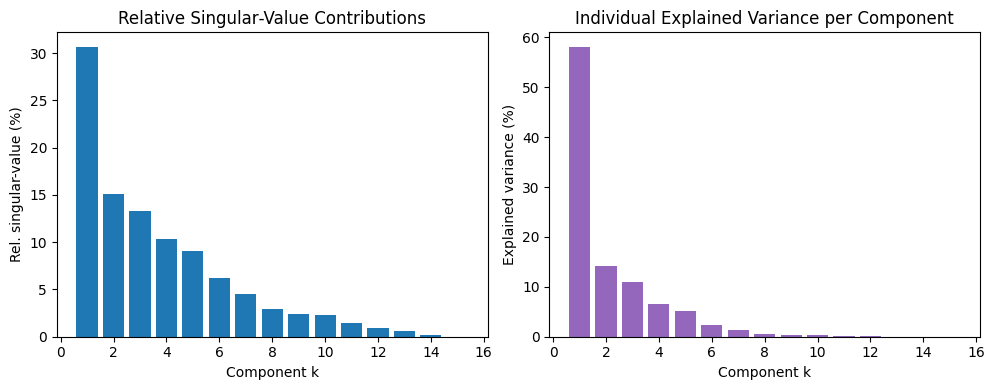

In [31]:
U, S, Vt = np.linalg.svd(X_scaled, full_matrices=False)
explained_var = (S**2) / np.sum(S**2)
rel_sv = S / np.sum(S)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].bar(np.arange(1,len(S)+1), rel_sv*100)
axes[0].set_xlabel("Component k")
axes[0].set_ylabel("Rel. singular-value (%)")
axes[0].set_title("Relative Singular‐Value Contributions")

axes[1].bar(np.arange(1,len(S)+1), explained_var*100, color='C4')
axes[1].set_xlabel("Component k")
axes[1].set_ylabel("Explained variance (%)")
axes[1].set_title("Individual Explained Variance per Component")
plt.tight_layout()
plt.show()

These plots show how much each SVD component “weighs” in your data:

Left: the share of total singular‐value mass (σₖ/∑σᵢ), with the first component alone contributing about 30 % and the next few rapidly declining.

Right: the analogous variance‐explained (σₖ²/∑σᵢ²), where the first component captures nearly 60 % of the variance, the second ~14 %, the third ~11 %, etc., implying that just the top 3–5 components recover most of the structure.

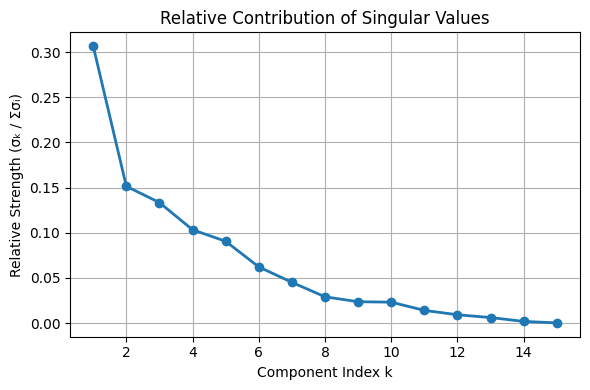

In [32]:
rel_strength = S / S.sum()         
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(S)+1), rel_strength, 'o-', linewidth=2)
plt.xlabel("Component Index k")
plt.ylabel("Relative Strength (σₖ / Σσᵢ)")
plt.title("Relative Contribution of Singular Values")
plt.grid(True)
plt.tight_layout()
plt.show()

This curve plots each component’s share of the total singular‐value “energy” (σₖ / ∑σᵢ) in descending order. You can see the first component alone accounts for roughly 30 % of the energy, the second about 15 %, and by the fifth it’s below 6 %, indicating that most of the signal is captured by just the first few components.

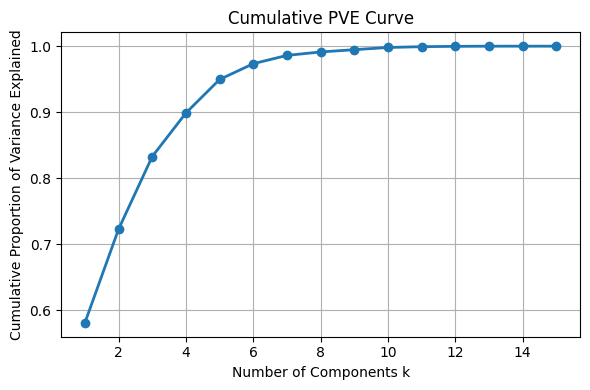

In [33]:
# 2) Cumulative PVE curve
explained_var = (S**2) / np.sum(S**2)
cum_pve = np.cumsum(explained_var)  # Σ_{i=1..k} (σᵢ²) / Σσⱼ²

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(cum_pve)+1), cum_pve, 'o-', linewidth=2)
plt.xlabel("Number of Components k")
plt.ylabel("Cumulative Proportion of Variance Explained")
plt.title("Cumulative PVE Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

This plot shows how the total variance in your standardized emission data accumulates as you include more SVD components:

By component 4 you already explain about 90 % of the variance, and by component 8 you’re up near 98 %.
It confirms that a low‐dimensional embedding (e.g. k=5–8) captures nearly all the meaningful structure in the full 15-feature space.

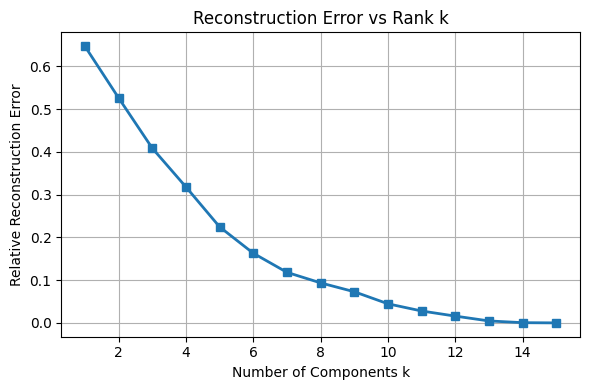

In [34]:
errors = []
normX = np.linalg.norm(X_scaled, 'fro')
for k in range(1, len(S)+1):
    Xk = U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :]
    errors.append(np.linalg.norm(X_scaled - Xk, 'fro') / normX)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(errors)+1), errors, 's-', linewidth=2)
plt.xlabel("Number of Components k")
plt.ylabel("Relative Reconstruction Error")
plt.title("Reconstruction Error vs Rank k")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def run_co2_experiment(missing_fractions, M_values, num_reps=5):
    """
    For each missing‐data fraction and each truncation rank M, randomly mask
    that fraction of X_scaled, perform matrix‐completion, and record RMSE.
    Prints a summary table of average RMSEs before plotting.
    """
    n, p = X_scaled.shape
    results = np.zeros((len(missing_fractions), len(M_values)))

    for i, frac in enumerate(missing_fractions):
        for rep in range(num_reps):
            # create random mask
            mask = np.zeros((n, p), dtype=bool)
            idx = np.random.choice(n * p, int(frac * n * p), replace=False)
            mask[np.unravel_index(idx, (n, p))] = True

            X_missing = X_scaled.copy()
            X_missing[mask] = np.nan

            for j, M in enumerate(M_values):
                X_hat, _, _ = matrix_completion(X_missing, mask, M=M)
                rmse = np.sqrt(np.mean((X_scaled[mask] - X_hat[mask])**2))
                results[i, j] += rmse

        # average over repetitions
        results[i, :] /= num_reps

    # build and print summary table
    df_results = pd.DataFrame(
        results,
        index=[f"{int(f*100)}%" for f in missing_fractions],
        columns=[f"M={M}" for M in M_values]
    )
    print("\nAverage Approximation Error (RMSE):")
    print(df_results)

    # plot the RMSE curves
    plt.figure(figsize=(8, 5))
    for j, M in enumerate(M_values):
        plt.plot(missing_fractions, results[:, j], marker='o', label=f"M={M}")
    plt.xlabel("Fraction Missing")
    plt.ylabel("RMSE of Reconstruction")
    plt.title("CO₂ Matrix Completion: RMSE vs Missing Fraction")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results, df_results



Average Approximation Error (RMSE):
          M=1       M=2       M=3       M=4       M=5       M=6       M=7  \
5%   0.634126  0.600675  0.491566  0.722175  0.679278  0.638345  0.606480   
10%  0.667859  0.618330  0.535441  0.750941  0.761550  0.656760  0.653338   
15%  0.649235  0.628929  0.558469  0.745248  0.772254  0.651062  0.614778   
20%  0.687230  0.654691  0.570586  0.769408  0.781044  0.654518  0.636117   
25%  0.673619  0.649351  0.597447  0.733004  0.806402  0.635950  0.621353   
30%  0.686268  0.677834  0.626993  0.713844  0.787330  0.645116  0.645740   

          M=8  
5%   0.596053  
10%  0.633424  
15%  0.606837  
20%  0.647340  
25%  0.630743  
30%  0.675430  


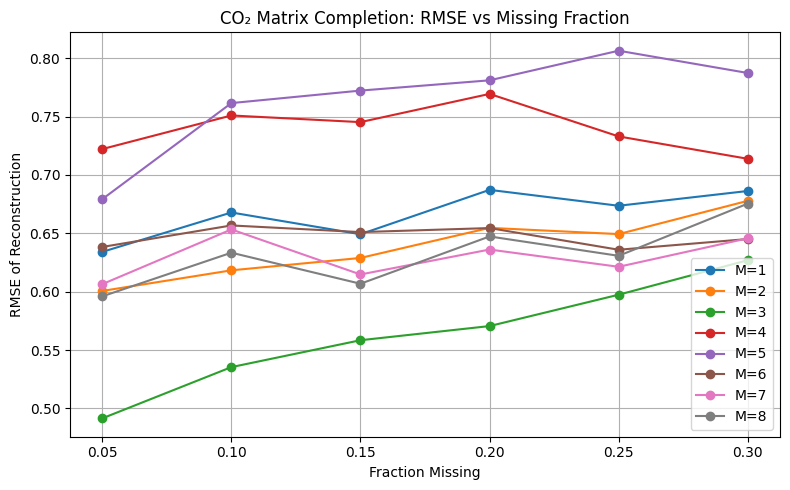

In [38]:
missing_fractions = np.arange(0.05, 0.35, 0.05)
M_values = [1, 2, 3, 4, 5, 6, 7, 8]
results, summary_df = run_co2_experiment(missing_fractions, M_values)


In [ ]:

pc_coords  = U[:, :8]

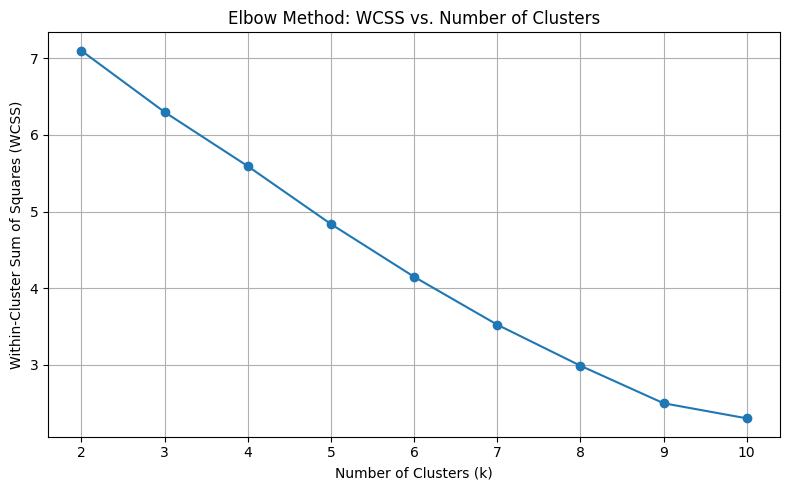

In [ ]:
Ks = range(2, 11)
inertias = []
sil_scores = []

for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(pc_coords)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(pc_coords, labels))

plt.figure(figsize=(8,5))
plt.plot(list(Ks), inertias, marker='o', linestyle='-')
plt.title("Elbow Method: WCSS vs. Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.xticks(Ks)
plt.grid(True)
plt.tight_layout()
plt.show()


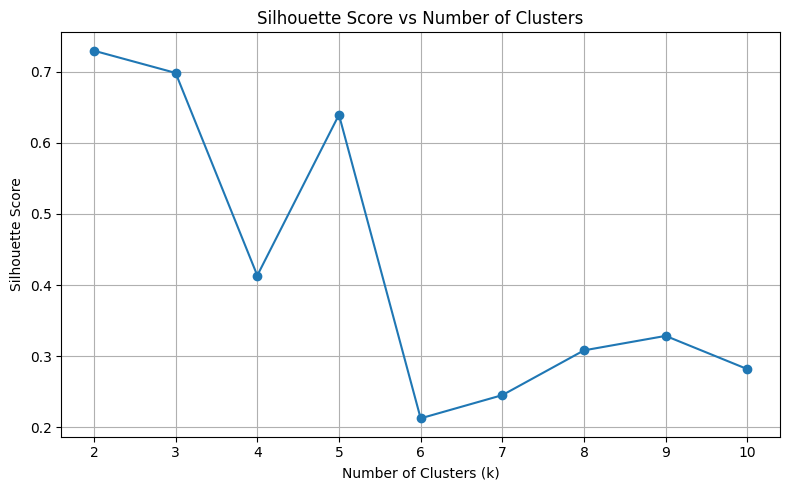

In [44]:
plt.figure(figsize=(8, 5))
plt.plot(list(Ks), sil_scores, marker='o', linestyle='-')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(Ks)
plt.grid(True)
plt.tight_layout()
plt.show()

The best number of clusters is 5 

In [50]:
labels = KMeans(n_clusters=5, n_init=10, random_state=42).fit_predict(T)
df['cluster'] = labels


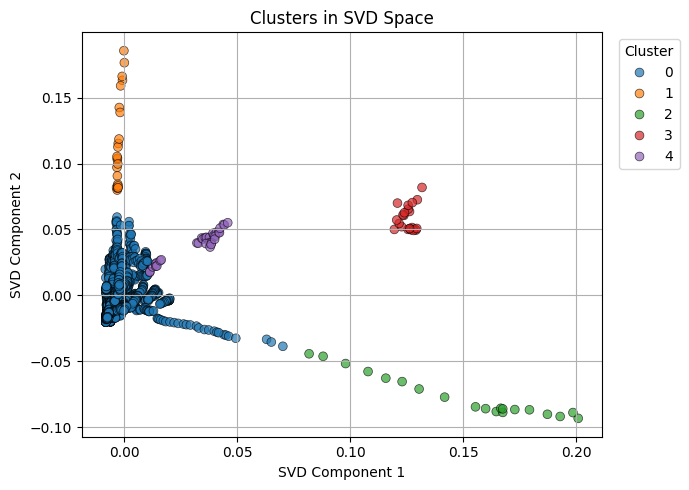

In [51]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=T[:,0], y=T[:,1], hue=labels, palette='tab10', s=40, edgecolor='k', alpha=0.7)
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.title("Clusters in SVD Space")
plt.legend(title="Cluster", bbox_to_anchor=(1.02,1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

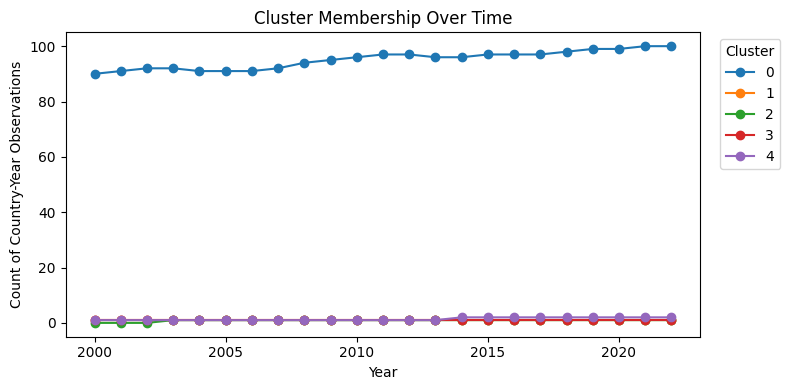

In [52]:
meta = df[['country','year','cluster']]
ts = meta.groupby(['year','cluster']).size().unstack(fill_value=0)
ts.plot(figsize=(8,4), marker='o')
plt.title("Cluster Membership Over Time")
plt.xlabel("Year")
plt.ylabel("Count of Country-Year Observations")
plt.legend(title="Cluster", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()